In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.stats import bootstrap
import astropy.units as u
from PIL import Image

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

ROOT = Path('../..').resolve()
results_dir = ROOT/'results/xSAGA-init'

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

#cosmology
c = FlatLambdaCDM(H0=70, Om0=0.3)


In [2]:
# sats after they've been crossmatched to hosts, in descending order of stellar mass
sats = pd.read_csv(results_dir/'sats_in_hosts.csv')

# SAGA-s2
saga_sats = pd.read_csv(ROOT/'data/saga_stage2_sats.csv')
saga_hosts = pd.read_csv(ROOT/'data/saga_stage2_hosts.csv', index_col='INTERNAL_HOSTID')

# More sanity checks on initial results (`sats_in_hosts` from nb 4)

## Surface brightness and color vs magnitude (Mao+2020 Fig 6)

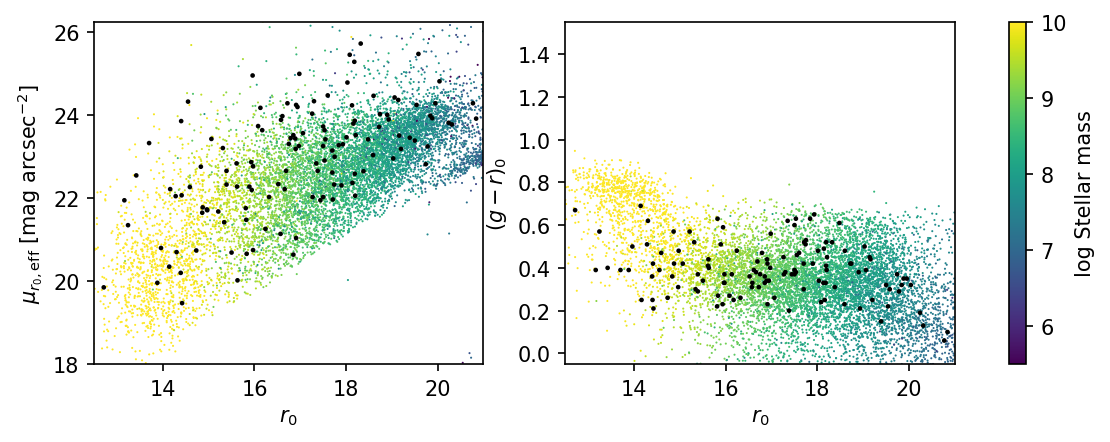

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.scatter(sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(12.5, 21)
ax1.set_ylim(18, 26.25)
ax1.set_xlabel(r'$r_0$')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

sc = ax2.scatter(sats.r0, sats.g0-sats.r0, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.R, saga_sats.GR, s=5, c='k', edgecolor='none')
ax2.set_xlim(12.5, 21)
ax2.set_ylim(-0.05, 1.55)
ax2.set_xlabel('$r_0$')
ax2.set_ylabel(r'$(g-r)_0$')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')



## Surface brightness vs physical radius and color (Mao+2020 Fig 9)

In [4]:
saga_sats['R_eff'] = np.sqrt(np.power(10, (saga_sats.MU_EFF - saga_sats.R) / 2.5) / (2*np.pi))
saga_sats['DIST'] = saga_hosts.loc[saga_sats.INTERNAL_HOSTID].DIST.values * 1000 # kpc
saga_sats['R_physical'] = (saga_sats.R_eff.values * u.arcsec).to(u.radian).value * saga_sats.DIST


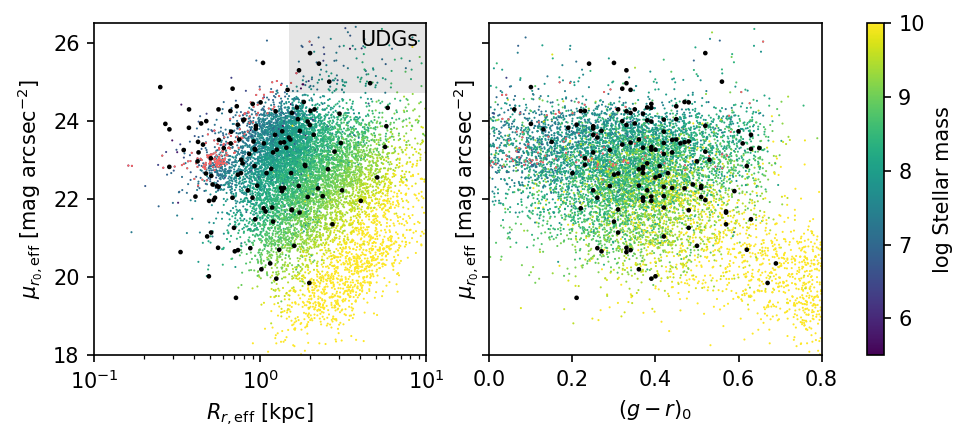

In [5]:
# Mao+2020 Fig 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True)

ax1.scatter(sats.R_physical, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(sats[sats.r0 > 20.75].R_physical, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.set_ylim(18, 26.5)
ax1.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax1.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax1.text(4, 25.9, 'UDGs', c='k')

sc = ax2.scatter(sats.g0-sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(sats[sats.r0 > 20.75].g0-sats[sats.r0 > 20.75].r0, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.GR, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax2.set_xlim(0, 0.8)
ax2.set_ylim(18, 26.5)
ax2.set_xlabel(r'$(g-r)_0$')
ax2.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')

Red points are those below SAGA completeness limit ($r_0 > 20.75$). Note that this plot includes more massive galaxies ($10^{10}$ $M_\odot$) that are larger, redder, and higher surface brightness than the others. These are probably quenched satellites in high-density environments.

# Satellites in relation to hosts

In [6]:
def load_NSA():
    """Returns dataframe with some NSA info.
    """
    nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

    # do this column by column, *not* on entire catalog
    byteorder = lambda x: x.byteswap().newbyteorder()

    # doesn't use .byteswap().newbyteorder() because that's super slow...
    return pd.DataFrame({
        'NSAID': byteorder(nsa.NSAID),
        'z_NSA': byteorder(nsa.Z),
        'ra_NSA': byteorder(nsa.RA),
        'dec_NSA': byteorder(nsa.DEC),
        'M_r_NSA': byteorder(nsa.ELPETRO_ABSMAG[:, 4]),
        'mass_NSA': byteorder(nsa.ELPETRO_MASS)
    })

In [7]:
# sats in hosts
sat_x_nsa = pd.read_csv(results_dir/'sat_x_NSA.csv')
sat_coords = SkyCoord(sat_x_nsa.ra, sat_x_nsa.dec, unit='deg')

# crossmatch hosts
nsa = load_NSA().set_index('NSAID')
nsa_coords = SkyCoord(nsa.ra_NSA, nsa.dec_NSA, unit='deg')

_, sep, _ = nsa_coords.match_to_catalog_sky(sat_coords)


In [8]:
hosts = nsa[sep < 1*u.deg].copy()
hosts = hosts[(hosts.mass_NSA < 1e14) & (hosts.mass_NSA > 1e8) & (hosts.z_NSA < 0.03) & (hosts.z_NSA > 0.005)].copy()

hosts.sort_values('mass_NSA', ascending=False, inplace=True)

len(hosts)

7891

Start with most massive hosts and work our way down, but now keep track of which host each satellite goes in. Save these host NSAIDs to the satellite dataframe. **Update -- getting rid of very nearby hosts, which will take up a huge swath of sky).**

In [9]:
host_dict = dict()

host_NSAID = -1 * np.ones(len(sat_x_nsa), dtype=int)
distances = -1 * np.ones(len(sat_x_nsa), dtype=float)

for host in tqdm(hosts.itertuples(), total=len(hosts)):
    nsaid, z, ra, dec, M_r, mass = host
    
    host_coords = SkyCoord(ra, dec, unit='deg')
    host_sep = host_coords.separation(sat_coords)
    
    kpc_per_deg = c.angular_diameter_distance(z).to(u.kpc).value * np.pi / 180 

    in_host = (host_sep.to(u.deg).value * kpc_per_deg < 300) # note: could change 300 kpc to something that scales with host mass 
    new_idxs = in_host & (host_NSAID == -1)    
    
    new_sats_in_host = sat_x_nsa[new_idxs]
    
    host_NSAID[new_idxs] = nsaid 
    distances[new_idxs] = host_sep[new_idxs] * kpc_per_deg
    
    n_sat_in_300kpc = len(new_sats_in_host)
    host_dict[nsaid] = [ra, dec, z, M_r, mass, n_sat_in_300kpc]


## Remake average number of satellites plot

In [10]:
host_df = pd.DataFrame.from_dict(
    host_dict, 
    orient='index', 
    columns=['ra', 'dec', 'z', 'M_r', 'mass', 'n_sat_in_300kpc'],
)
host_df.index.name = 'NSAID'
host_df.sample(5, random_state=42)

,ra,dec,z,M_r,mass,n_sat_in_300kpc
NSAID,,,,,,
335570,237.971010,25.978340,0.022026,-19.598730,5.569860e+09,2
444764,182.467186,38.730026,0.021305,-16.465109,5.007998e+08,0
433370,166.442148,37.618204,0.025043,-19.150024,6.555668e+09,0
293381,164.313011,46.753671,0.022692,-17.976593,2.121717e+09,1
249850,224.599357,41.941446,0.028242,-17.582291,6.843204e+08,0


**Correcting for self-matches**.

Attach these host properties to `sat_x_nsa`

In [11]:
sat_x_nsa['host_distance'] = distances
sat_x_nsa['host_NSAID'] = host_NSAID

sdf = sat_x_nsa.join(hosts, on='host_NSAID', how='left', rsuffix='_HOST')
sdf.sample(5)

,objID,ra,dec,g0,r0,R_eff,p_sat,sep_NSA,NSAID,z_NSA,ra_NSA,dec_NSA,M_r_NSA,host_distance,host_NSAID,z_NSA_HOST,ra_NSA_HOST,dec_NSA_HOST,M_r_NSA_HOST,mass_NSA
3523,1237660635457912898,154.985826,43.319745,16.20831,15.93773,5.245109,0.974697,0.333850,234769,0.012542,154.985953,43.319751,-17.535755,225.386114,234738,0.025969,154.826084,43.349053,-18.880499,3.792040e+09
5223,1237661850385317913,153.497772,39.803517,17.14326,16.98339,5.807485,0.908395,16.540555,269069,0.006961,153.493296,39.800470,-16.640991,286.367044,269083,0.022787,153.694561,39.887479,-17.663464,1.523096e+09
4269,1237655348355203529,239.275812,48.050340,18.29767,17.83421,3.632635,0.969886,0.234286,141784,0.018397,239.275763,48.050397,-16.078138,169.841874,141787,0.019661,239.262573,48.168379,-21.335079,5.040224e+10
3563,1237658203421999353,137.194487,37.499134,16.36583,15.60594,15.101500,0.967819,14.203045,591773,0.022820,137.198391,37.501578,-20.392930,212.539633,175089,0.023153,137.155400,37.621589,-21.589088,6.421239e+10
2994,1237664337179574306,177.755756,36.490456,14.48149,13.91074,6.449004,0.974668,0.015138,435022,0.021182,177.755760,36.490453,-20.272545,0.006488,435022,0.021182,177.755760,36.490453,-20.272545,1.109129e+10


In [12]:
# self-match NSAIDs
self_matches_NSAIDs = sdf.NSAID[sdf.NSAID == sdf.host_NSAID]

# subtract 1 from each of these
host_df['n_sat_in_300kpc'] = np.where(
    host_df.index.isin(self_matches_NSAIDs),
    host_df.n_sat_in_300kpc - 1,
    host_df.n_sat_in_300kpc
)

In [47]:
from matplotlib.colors import LogNorm

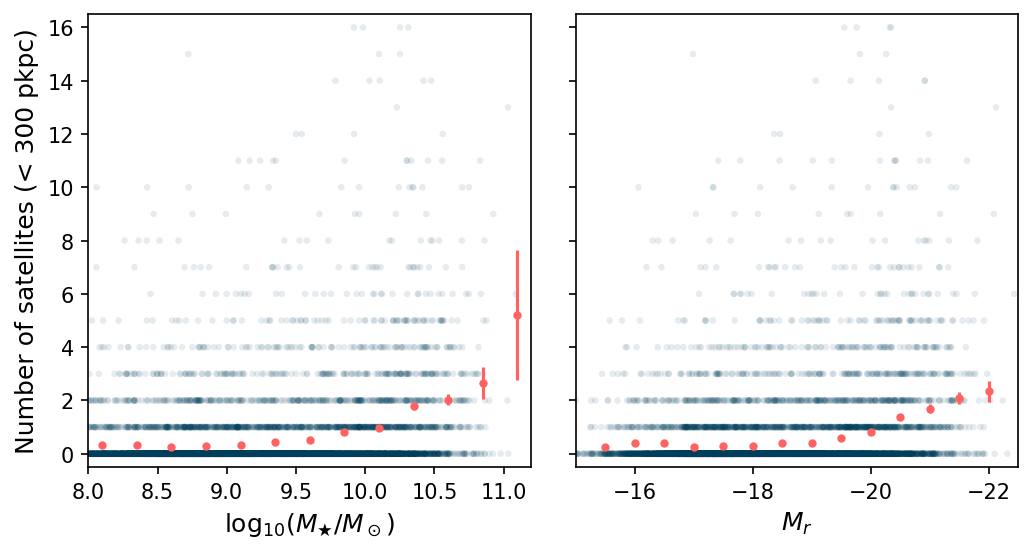

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

# plot stellar mass
ax1.scatter(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, edgecolors='none', s=10, alpha=0.1, c=c0)

mass_bins = np.arange(8., 11.5, 0.25)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    ) for m1, m2 in zip(mass_bins[:-1], mass_bins[1:])]
)

ax1.errorbar(mass_bins[:-1]+0.1, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax1.set_xlim(8.0, 11.2)
ax1.set_ylim(-0.5, 16.5)
ax1.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax1.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

# plot abs mag
ax2.scatter(host_df.M_r, host_df.n_sat_in_300kpc, edgecolors='none', s=10, alpha=0.1, c=c0)

mag_bins = np.arange(-22., -14.5, 0.5)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.M_r > mag1) & (host_df.M_r < mag2)].values,
        bootfunc=np.mean,
    ) for mag1, mag2 in zip(mag_bins[:-1], mag_bins[1:])]
)
ax2.errorbar(mag_bins[:-1], boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax2.set_xlim(-15, -22.5)
ax2.set_xlabel(r'$M_{r}$', fontsize=12)

fig.subplots_adjust(wspace=0.1)



Plot again but with a 2d histogram below the mean trend.

In [72]:
len(mass_bins)

14

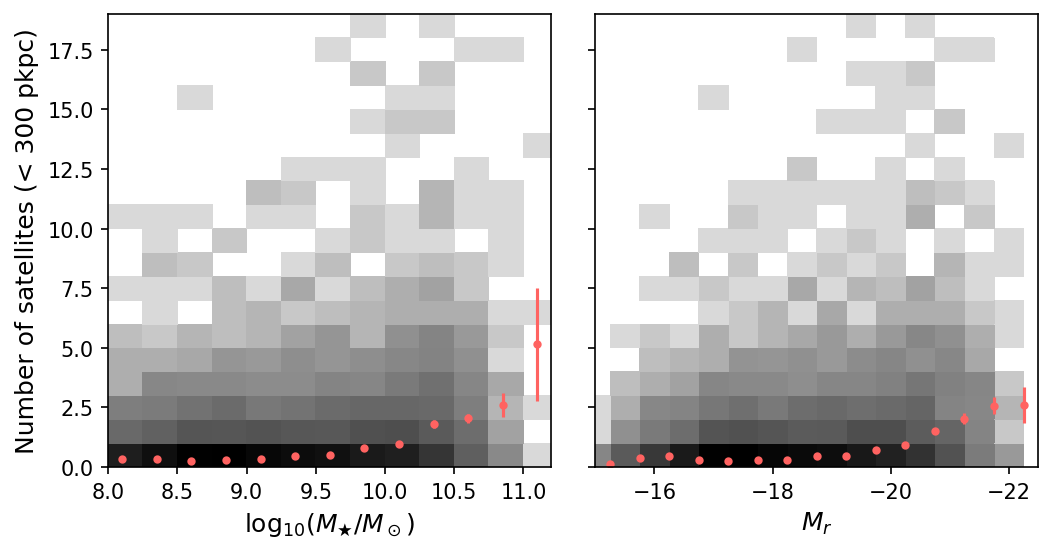

In [87]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

# plot stellar mass
mass_bins = np.arange(8., 11.5, 0.25)
ax1.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e3))

boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    ) for m1, m2 in zip(mass_bins[:-1], mass_bins[1:])]
)

ax1.errorbar(mass_bins[:-1]+0.1, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax1.set_xlim(8.0, 11.2)
ax1.set_ylim(-0.5, 20.5)
ax1.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax1.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

# plot abs mag
ax2.hist2d(host_df.M_r, host_df.n_sat_in_300kpc, edgecolors='none', bins=(mag_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e3))

mag_bins = np.arange(-22.25, -14.5, 0.5)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.M_r > mag1) & (host_df.M_r < mag2)].values,
        bootfunc=np.mean,
    ) for mag1, mag2 in zip(mag_bins[:-1], mag_bins[1:])]
)
ax2.errorbar(mag_bins[:-1], boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax2.set_xlim(-15, -22.5)
ax2.set_xlabel(r'$M_{r}$', fontsize=12)

fig.subplots_adjust(wspace=0.1)



1192
2251
1789
1404
1033
216


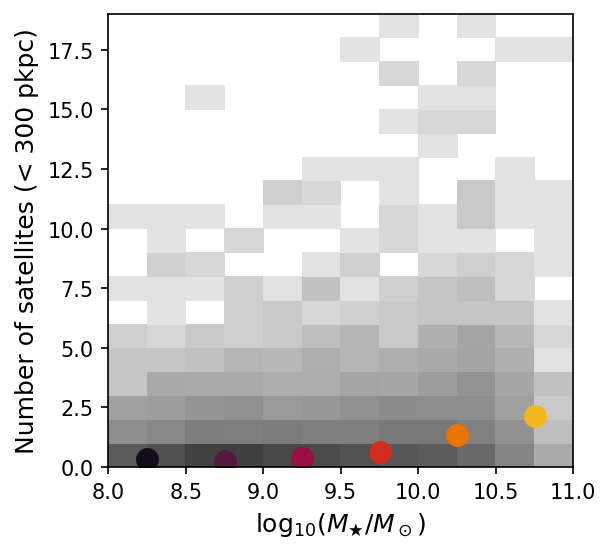

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# plot stellar mass
mass_bins = np.arange(8., 11.25, 0.25)
ax.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e4))

for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):
    
    boot_n_sat = bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    )
    
    print(sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)))
    
    ax.errorbar((m1+m2)/2, boot_n_sat.mean(), yerr=boot_n_sat.std(), color=color, marker='o', markersize=10)
    
ax.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

## Radial distribution of satellites

Again, remove self-matches (now from `sdf`)

In [14]:
sdf = sdf[sdf.NSAID != sdf.host_NSAID].copy()
sdf.sample(5)

,objID,ra,dec,g0,r0,R_eff,p_sat,sep_NSA,NSAID,z_NSA,ra_NSA,dec_NSA,M_r_NSA,host_distance,host_NSAID,z_NSA_HOST,ra_NSA_HOST,dec_NSA_HOST,M_r_NSA_HOST,mass_NSA
719,1237661873488658565,219.815406,40.062252,16.35369,16.01114,4.260859,0.918656,883.649528,266987,0.026133,219.499773,40.106212,-20.573357,292.347772,682430,0.009041,219.567917,40.456753,-19.241602,4.597409e+09
7678,1237661965818331171,181.401285,41.290656,24.32643,19.06547,3.952831,0.945695,5.966730,627751,0.003442,181.400544,41.289095,-13.833918,-1.000000,-1,NaN,NaN,NaN,NaN,NaN
1778,1237661849856245781,176.858757,43.758616,15.06542,14.59768,5.498516,0.922323,0.323980,272779,0.024745,176.858850,43.758556,-19.677069,128.864270,272286,0.025232,176.955218,43.748192,-20.116009,9.934725e+09
3447,1237658203436220648,179.549172,48.885367,19.65936,19.39372,2.582084,0.862443,14.840322,664582,0.002780,179.547236,48.881446,-14.801794,-1.000000,-1,NaN,NaN,NaN,NaN,NaN
5371,1237661434308132898,184.203590,47.457390,14.27698,13.67550,8.295236,0.973678,0.069539,298344,0.024736,184.203582,47.457408,-20.797466,32.639147,298347,0.024194,184.204274,47.438809,-20.910343,2.744395e+10


248 129
359 197
457 223
663 295
1029 367
373 116


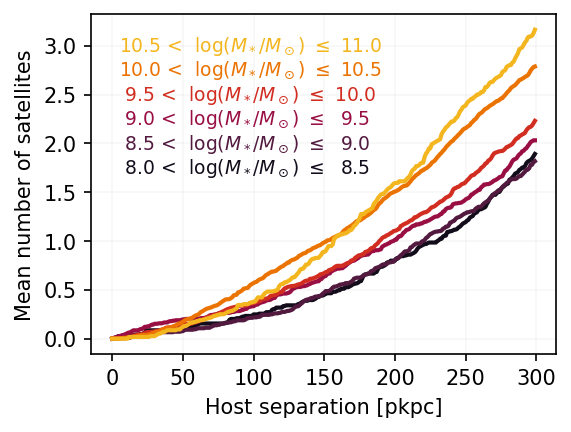

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)
#     N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=2)
    
    ax.text(5, 1.75+i/4, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

248 1192
359 2251
457 1789
663 1404
1029 1033
373 216


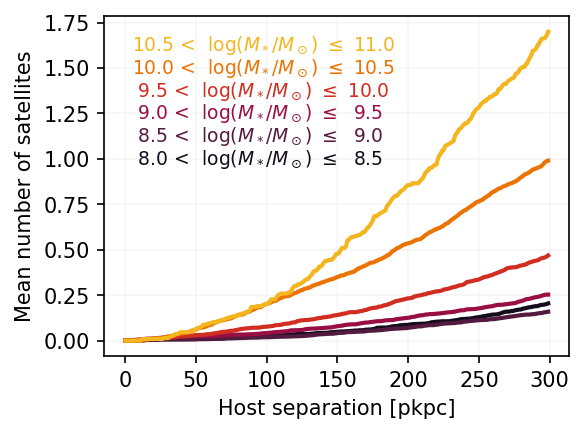

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=2)
    
    ax.text(5, 1+i/8, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

1029 1033
373 216


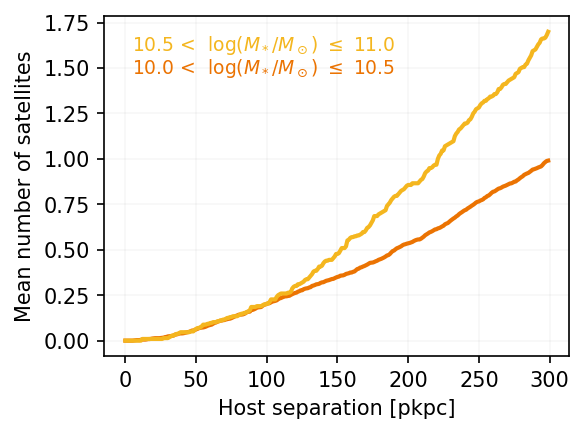

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(10, 11, 0.5), np.arange(10.5, 11.5, 0.5), cmr.ember([0.74, 0.9]))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=2)
    
    ax.text(5, 1.5+i/8, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

### Another way of slicing up mass bins

752
652
601
432
175
41


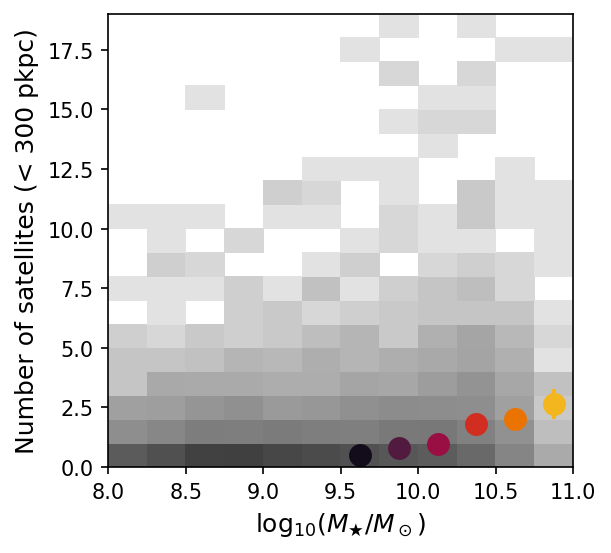

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# plot stellar mass
mass_bins = np.arange(8., 11.25, 0.25)
ax.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e4))

for i, (m1, m2, color) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)))):
    
    boot_n_sat = bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    )
    
    print(sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)))
    
    ax.errorbar((m1+m2)/2, boot_n_sat.mean(), yerr=boot_n_sat.std(), color=color, marker='o', markersize=10, lw=2)
    
ax.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

290 752
373 652
416 601
613 432
279 175
94 41


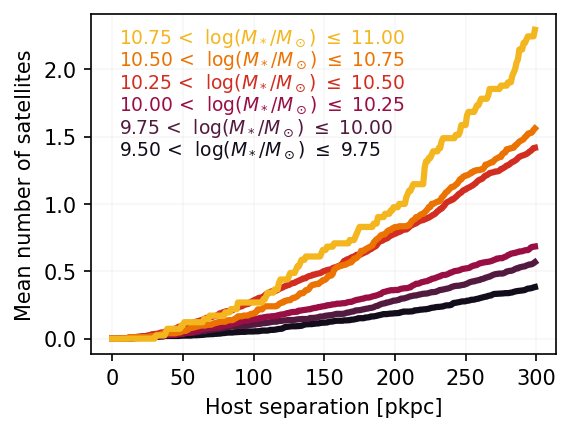

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(5, 1.4+i/6, f'{m1:>4.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

290 752
373 652
416 601
613 432
279 175
94 41


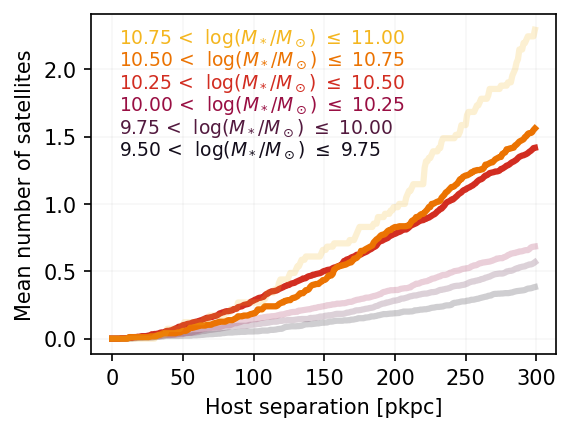

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color, alpha) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)), [0.2, 0.2, 0.2, 1, 1, 0.2])):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=3, alpha=alpha)
    
    ax.text(5, 1.4+i/6, f'{m1:>4.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

Bootstrap resample (with std errors) on separate subplots

290 752
373 652
416 601
613 432
279 175
94 41


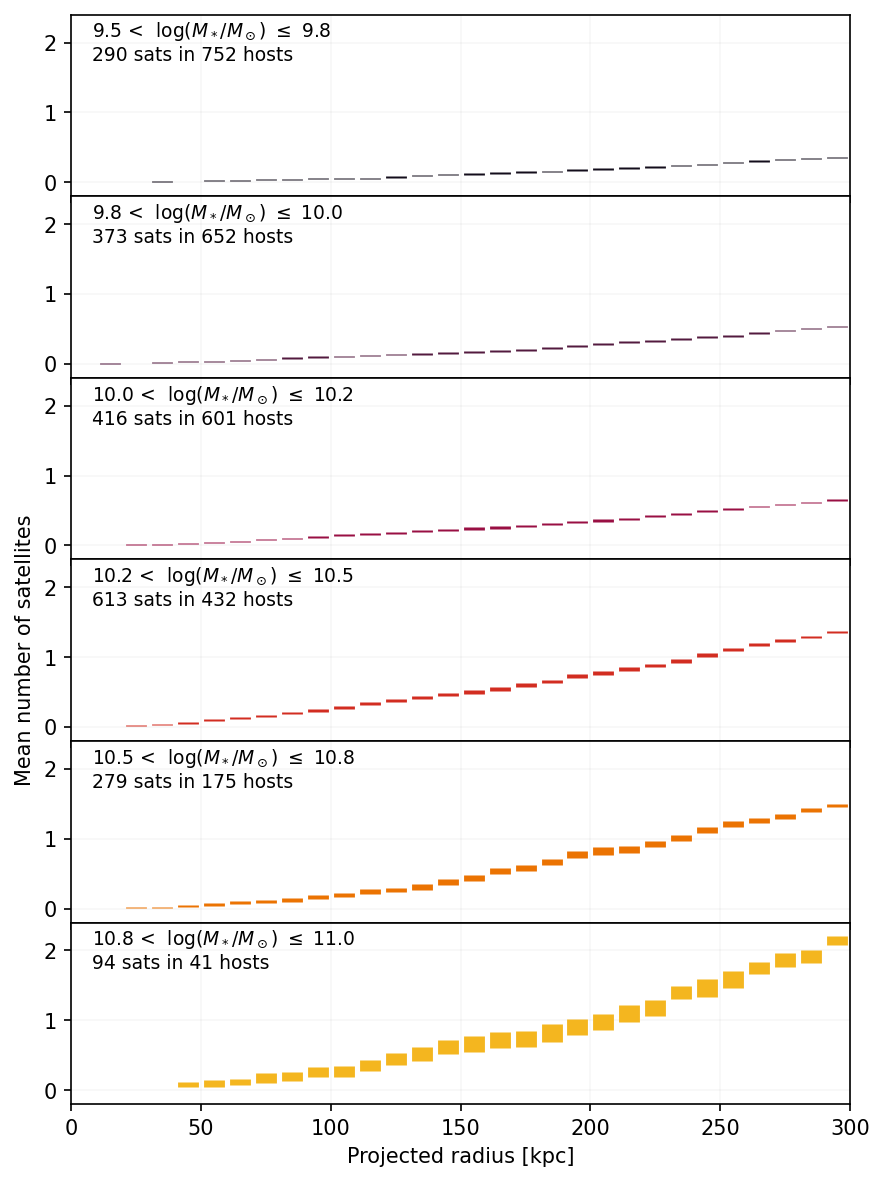

In [169]:
fig, axes = plt.subplots(6, 1, figsize=(6, 8), dpi=150, sharex=True)

radius_range = np.arange(0, 300, 10)

# loop through mass bins
for i, (m1, m2, color, ax) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)), axes.flat)):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2) & (sdf.host_distance > 0)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)


    print(N_sats, N_hosts)
    
    boot_cdf_sat = np.array([
        bootstrap(
            sdf[in_mass_range].host_distance.values,
            bootfunc=lambda x: sum((x < r)) / N_hosts
        ) for r in radius_range
    ])
    
    ax.errorbar(radius_range+5, boot_cdf_sat.mean(1), boot_cdf_sat.std(1), c=color, lw=10, ls='')
    ax.set_xlim(0, 300)
    ax.set_ylim(-0.2, 2.4)
    ax.grid(alpha=0.1)
    
    
    ax.text(8, 2.0, f'{m1:.1f} <  log($M_*/M_\odot$) $\leq$ {m2:.1f}' '\n' f'{N_sats} sats in {N_hosts} hosts', va='center',fontsize=9)
    
axes.flat[-1].set_xlabel('Projected radius [kpc]')
axes.flat[3].set_ylabel('Mean number of satellites')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

### Look at two host bins

613
279


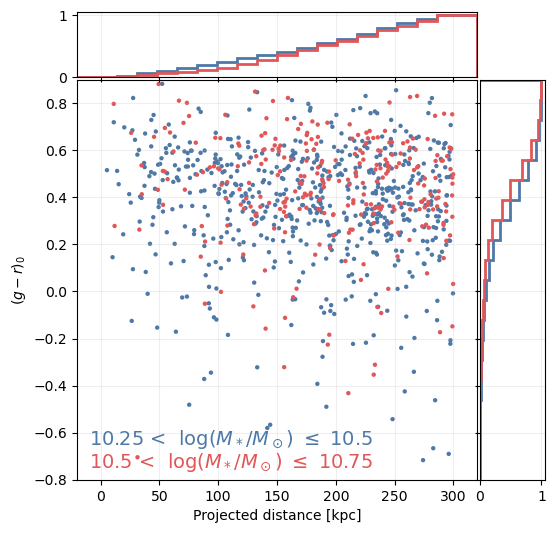

In [168]:
# organize data
sdf_a = sdf[(sdf.mass_NSA > 10**10.25) & (sdf.mass_NSA <= 10**10.5)]
sdf_b = sdf[(sdf.mass_NSA > 10**10.5) & (sdf.mass_NSA <= 10**10.75)]
sdf_c = sdf[(sdf.mass_NSA > 10**10.75) & (sdf.mass_NSA <= 10**11)]


# organize subplots
left, width = 0.07, 0.8
bottom, height = 0.07, 0.8
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.13]
rect_histy = [left + width + spacing, bottom, 0.13, height]

fig = plt.figure(figsize=(5, 5), dpi=100)

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# plot

ax.set_xlim(-20, 320)
ax.set_ylim(-0.8, 0.9)

for df_, color in zip([sdf_a, sdf_b], ['#4e79a7', '#e15759']):
    ax.scatter(df_.host_distance, df_.g0-df_.r0, color=color, s=10, edgecolor='none')
    ax_histx.hist(df_.host_distance, density=True, cumulative=True, bins=20, range=ax.get_xlim(), color=color, histtype='step', lw=2)
    ax_histy.hist(df_.g0-df_.r0, density=True, cumulative=True, bins=20, range=ax.get_ylim(), color=color, orientation='horizontal', histtype='step', lw=2)
    print(len(df_))

ax.grid(alpha=0.2)
ax_histx.grid(alpha=0.2)
ax_histy.grid(alpha=0.2)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.text(-10, -0.65, '10.25 <  log($M_*/M_\odot$) $\leq$ 10.5', color='#4e79a7', fontsize=14)
ax.text(-10, -0.75, '10.5 <  log($M_*/M_\odot$) $\leq$ 10.75', color='#e15759', fontsize=14)

ax.set_xlabel('Projected distance [kpc]')
ax.set_ylabel(r'$(g-r)_0$')

plt.show()

### Investigating galaxies within 50-150 kpc and in the most massive hosts

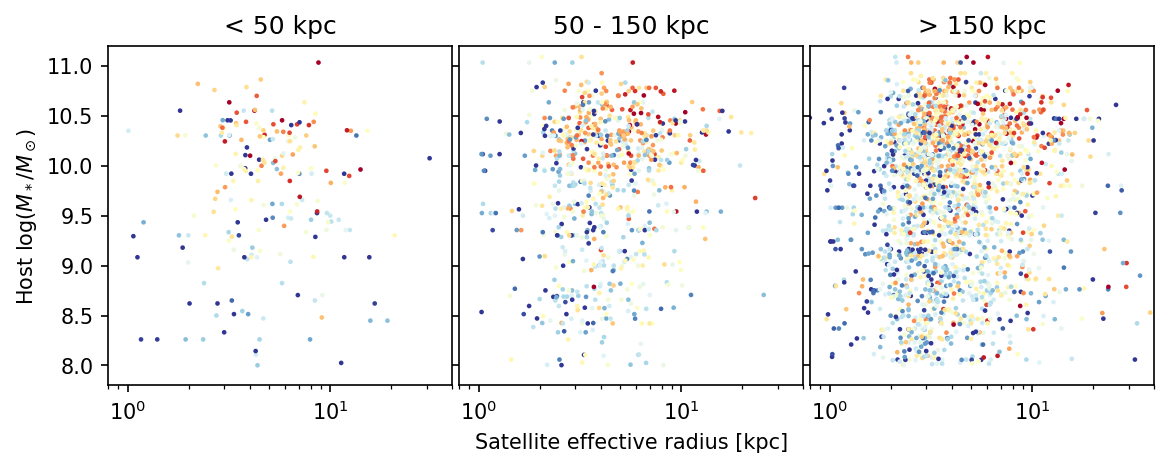

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150, sharey=True)

for ax, crit, title in zip(
    axes.flat, 
    [(sdf.host_distance < 50), (sdf.host_distance > 50) & (sdf.host_distance < 150), (sdf.host_distance > 150)],
    ['< 50 kpc', '50 - 150 kpc', '> 150 kpc']
):
    sdf_vir = sdf[crit]
    
    ax.scatter(sdf_vir.R_eff, np.log10(sdf_vir.mass_NSA), s=5, edgecolor='none', c=sdf_vir.g0-sdf_vir.r0, vmin=0, vmax=0.8, cmap='RdYlBu_r')
    ax.set_xscale('log')
    ax.set_xlim(0.8, 40)
    ax.set_ylim(7.8, 11.2)
    ax.set_title(title);

axes.flat[1].set_xlabel('Satellite effective radius [kpc]')
axes.flat[0].set_ylabel('Host log($M_*/M_\odot$)')
fig.subplots_adjust(wspace=0.02)

## Other quantities in relation to distance from host

In [21]:
sdf['mu_eff'] = sdf.r0 + 5*np.log10(sdf.R_eff) + 2.5*np.log10(2*np.pi)

# assuming that it is at the redshift of the host
sdf['DIST'] = c.luminosity_distance(sdf.z_NSA_HOST).to(u.Mpc).value
sdf['M_r'] = sdf.r0 - 5*np.log10(sdf.DIST*1e6) + 5
sdf['logmass_sat'] = 1.254 + 1.098*(sdf.g0-sdf.r0) - 0.4*sdf.M_r

sdf['R_physical'] = (sdf.R_eff.values * u.arcsec).to(u.radian).value * sdf.DIST*1e3


/home/john/anaconda3/envs/xSAGA/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Save `sdf` in this notebook... (and get rid of old one)

In [30]:
sdf.to_csv(results_dir/'sats_in_hosts_nb5.csv', index=False)
sdf = pd.read_csv(results_dir/'sats_in_hosts_nb5.csv')

### Colored by $g-r$ color

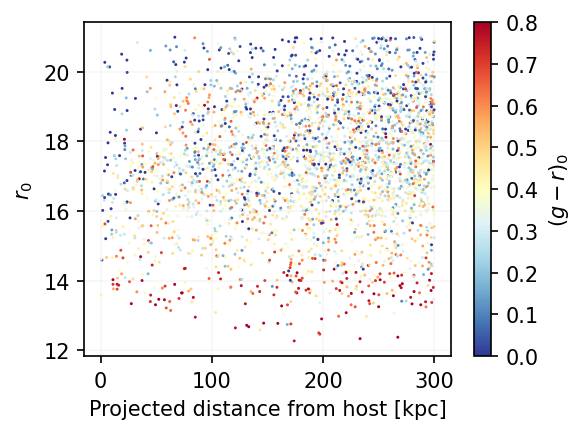

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].r0, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'$r_0$')

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

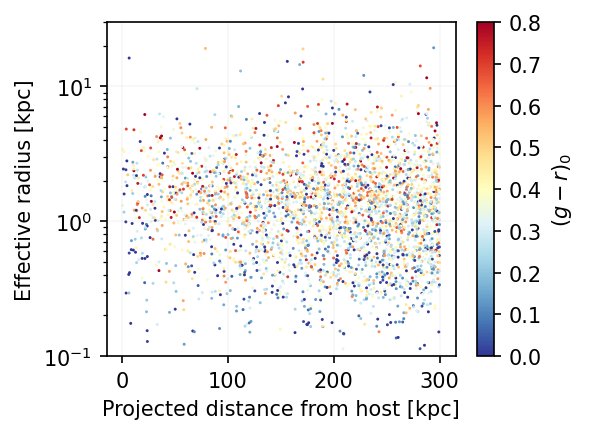

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'Effective radius [kpc]')

ax.grid(alpha=0.1)
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

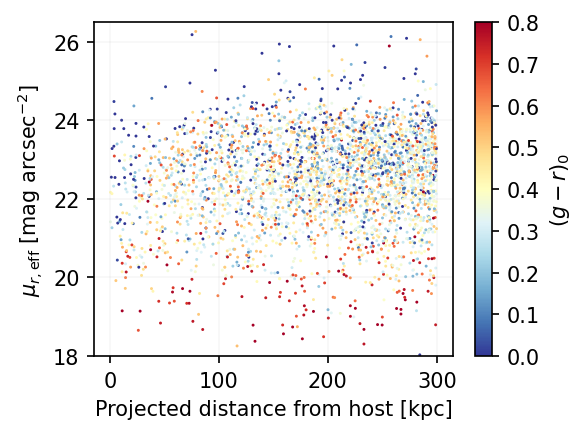

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')

ax.grid(alpha=0.1)
ax.set_ylim(18, 26.5)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

### Colored by distance from host

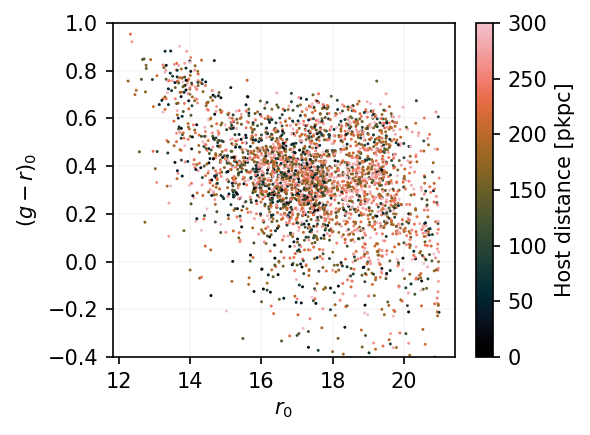

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    (sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'$(g-r)_0$')
ax.set_ylim(-0.4, 1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

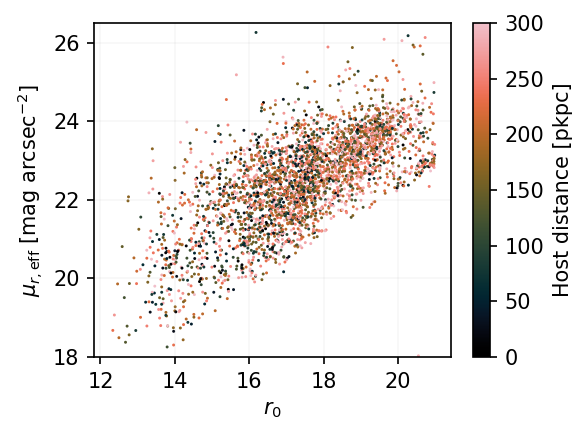

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')
ax.set_ylim(18, 26.5)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

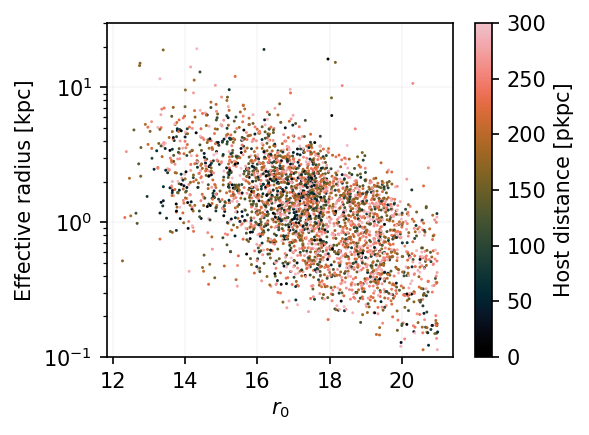

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'Effective radius [kpc]')
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

Based on these results, I'm not seeing any strong biases as a function of host distance or $r_0$

### Same as above but with absolute mag

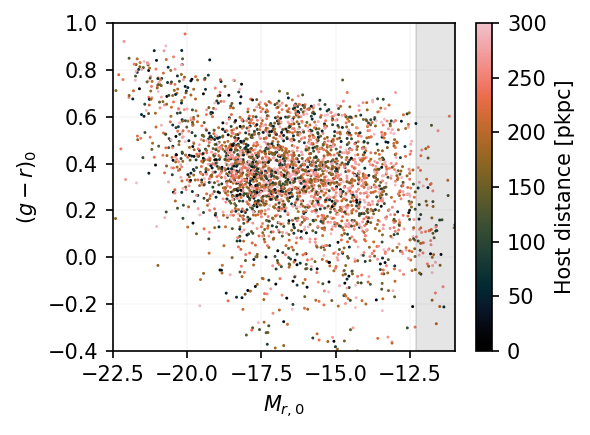

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    (sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_ylabel(r'$(g-r)_0$')
ax.set_xlim(-22.5, -11)
ax.set_ylim(-0.4, 1)

ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

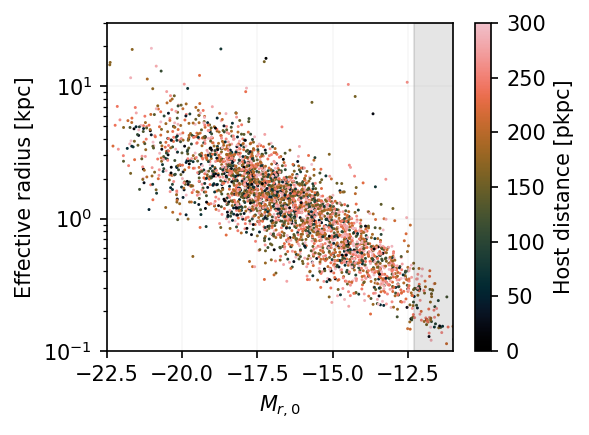

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_xlim(-22.5, -11)

ax.set_ylabel(r'Effective radius [kpc]')
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

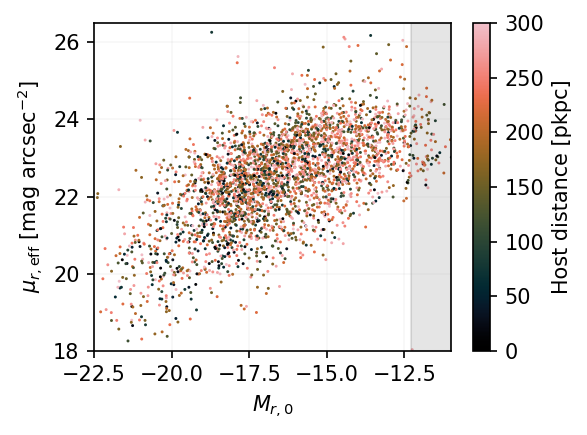

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_xlim(-22.5, -11)
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')
ax.set_ylim(18, 26.5)
ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

## Remake Mao+2020 plots

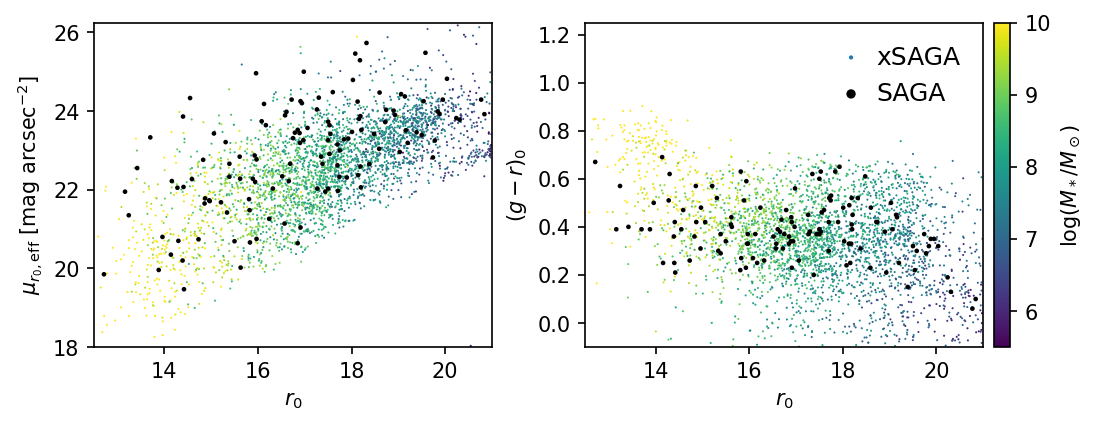

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.scatter(sdf.r0, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(12.5, 21)
ax1.set_ylim(18, 26.25)
ax1.set_xlabel(r'$r_0$')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

sc = ax2.scatter(sdf.r0, sdf.g0-sdf.r0, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10, label='xSAGA')
ax2.scatter(saga_sats.R, saga_sats.GR, s=5, c='k', edgecolor='none', label='SAGA')
ax2.set_xlim(12.5, 21)
ax2.set_ylim(-0.1, 1.25)
ax2.set_xlabel('$r_0$')
ax2.set_ylabel(r'$(g-r)_0$')

ax2.legend(fontsize=12, markerscale=2, framealpha=0, handletextpad=0.02)

fig.tight_layout(pad=1.5)

cb = fig.colorbar(sc, ax=[ax1, ax2], pad=0.01)
cb.set_label(r'log($M_*/M_\odot$)')


It seems that our CNN finds candidates that are very blue: $(g-r)_0 < 0.2$.

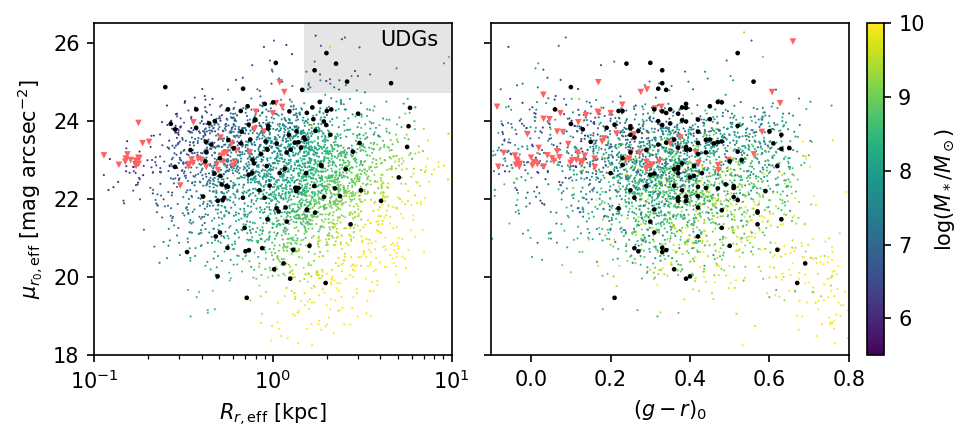

In [40]:
# Mao+2020 Fig 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True)

ax1.scatter(sdf.R_physical, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(sdf[sdf.r0 > 20.75].R_physical, sdf[sdf.r0 > 20.75].mu_eff, c=c3, s=10, edgecolor='none', marker='v', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.set_ylim(18, 26.5)
ax1.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax1.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax1.text(4, 25.9, 'UDGs', c='k')

sc = ax2.scatter(sdf.g0-sdf.r0, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(sdf[sdf.r0 > 20.75].g0-sdf[sdf.r0 > 20.75].r0, sdf[sdf.r0 > 20.75].mu_eff, c=c3, s=10, marker='v', edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.GR, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax2.set_xlim(-0.1, 0.8)
ax2.set_ylim(18, 26.5)
ax2.set_xlabel(r'$(g-r)_0$')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2], pad=0.02)
cb.set_label(r'log($M_*/M_\odot$)')

There are also quite a few large galaxies with high surface brightnesses. My intuition is that these are just red galaxies in group or cluster environments.

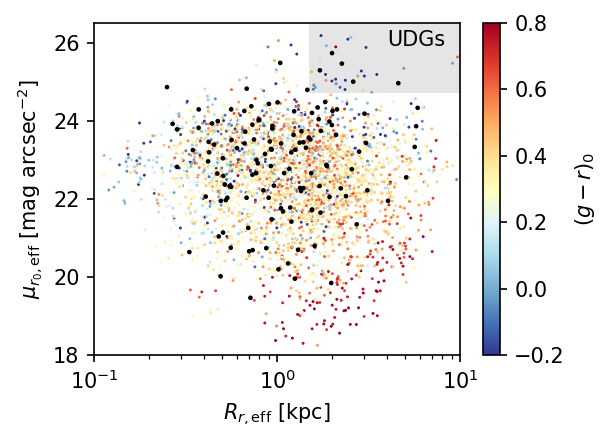

In [41]:
# Mao+2020 Fig 9
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150, sharey=True)

sc = ax.scatter(sdf.R_physical, sdf.mu_eff, c=sdf.g0-sdf.r0, s=2, edgecolor='none', vmin=-0.2, vmax=0.8, cmap='RdYlBu_r')
ax.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax.set_xlim(0.1, 10)
ax.set_xscale('log')
ax.set_ylim(18, 26.5)
ax.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax.text(4, 25.9, 'UDGs', c='k')


fig.tight_layout()

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')